C:\Users\HerbyHerb\AppData\Local\Temp\ipykernel_11260\940105265.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, connection)


Epoch 1/50
17/17 [==============================] - 3s 13ms/step - loss: 0.1328
Epoch 2/50
17/17 [==============================] - 0s 11ms/step - loss: 0.0216
Epoch 3/50
17/17 [==============================] - 0s 11ms/step - loss: 0.0133
Epoch 4/50
17/17 [==============================] - 0s 11ms/step - loss: 0.0104
Epoch 5/50
17/17 [==============================] - 0s 11ms/step - loss: 0.0097
Epoch 6/50
17/17 [==============================] - 0s 11ms/step - loss: 0.0088
Epoch 7/50
17/17 [==============================] - 0s 11ms/step - loss: 0.0080
Epoch 8/50
17/17 [==============================] - 0s 12ms/step - loss: 0.0078
Epoch 9/50
17/17 [==============================] - 0s 12ms/step - loss: 0.0073
Epoch 10/50
17/17 [==============================] - 0s 12ms/step - loss: 0.0071
Epoch 11/50
17/17 [==============================] - 0s 12ms/step - loss: 0.0067
Epoch 12/50
17/17 [==============================] - 0s 12ms/step - loss: 0.0066
Epoch 13/50
17/17 [==================

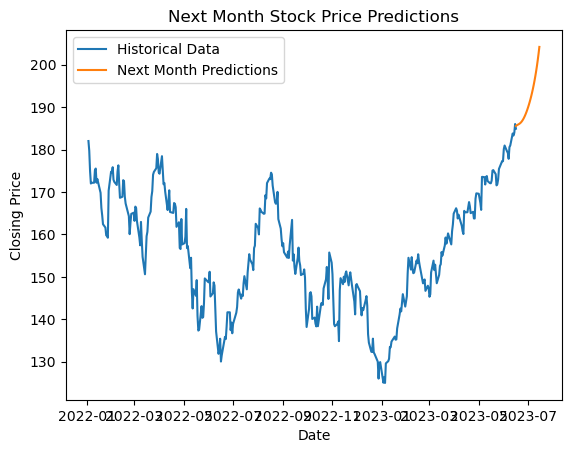

In [9]:
import numpy as np
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Verbindungsstring zur MS SQL-Datenbank
conn_str = (
    r'Driver={SQL Server};'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur MS SQL-Datenbank herstellen und Daten abrufen
connection = pyodbc.connect(conn_str)
query = "SELECT timestamp, o, c, h, l FROM stock_data ORDER BY timestamp"
data = pd.read_sql(query, connection)

# Daten vorbereiten
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['c']])

# Trainingsdaten und Labels erstellen
lookback = 30  # Anzahl der vergangenen Tage, die als Eingabe verwendet werden
X = []
y = []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)

# Daten aufteilen in Trainings- und Testdaten
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM-Modell erstellen
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(lookback, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Modell trainieren
model.fit(X_train, y_train, epochs=50, batch_size=16)

# Vorhersage für den nächsten Monat machen
last_month_data = scaled_data[-lookback:]  # Die letzten lookback Tage als Eingabe
next_month_predictions = []
for _ in range(30):  # 30 Tage im nächsten Monat
    prediction = model.predict(last_month_data.reshape(1, lookback, 1))
    next_month_predictions.append(prediction[0])
    last_month_data = np.append(last_month_data[1:], prediction[0])

# Inverse Skalierung der Vorhersagen
next_month_predictions = scaler.inverse_transform(np.array(next_month_predictions).reshape(-1, 1))

# Vorhersagen plotten
predictions_index = pd.date_range(start=data['timestamp'].iloc[-1], periods=30, freq='D')
predictions_df = pd.DataFrame(next_month_predictions, index=predictions_index, columns=['Prediction'])
plt.plot(data['timestamp'], data['c'], label='Historical Data')
plt.plot(predictions_df.index, predictions_df['Prediction'], label='Next Month Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Next Month Stock Price Predictions')
plt.legend()
plt.show()


1/1 [==============================] - 0s 52ms/step


C:\Users\HerbyHerb\AppData\Local\Temp\ipykernel_11260\365058282.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, connection)


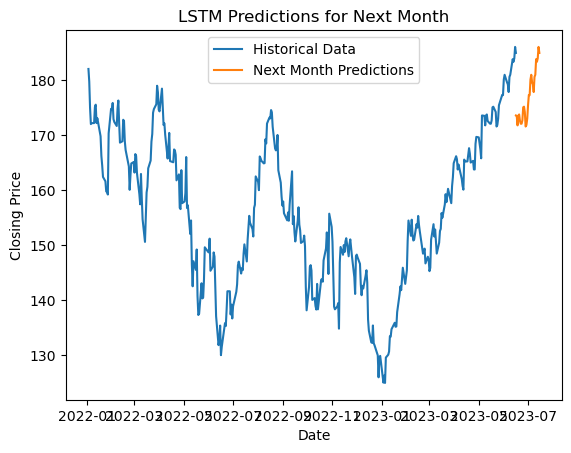

In [11]:
# Daten aus der SQL-Datenbank abrufen
query = "SELECT timestamp, o, c, h, l FROM stock_data ORDER BY timestamp"
data = pd.read_sql(query, connection)

# Den Index als DatetimeIndex setzen
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Aufteilung in Trainings- und Testdaten
train_data = data.iloc[:-30]  # Alle Daten außer den letzten 30 Tagen
test_data = data.iloc[-30:]  # Die letzten 30 Tage als Testdaten

# Modell erstellen und trainieren
model = Sequential()
# ...

# Vorhersage für den nächsten Monat
next_month_predictions = model.predict(test_data)

# Index für die Vorhersage erstellen
predictions_index = pd.date_range(start=data.index[-1], periods=30, freq='D')
predictions_df = pd.DataFrame(next_month_predictions, index=predictions_index, columns=['o', 'c', 'h', 'l'])

# Plot der historischen Daten und Vorhersagen
plt.plot(data.index, data['c'], label='Historical Data')
plt.plot(predictions_df.index, predictions_df['c'], label='Next Month Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('LSTM Predictions for Next Month')
plt.legend()
plt.show()
